# Reshape

**Outcomes**
- Understand and be able to apply the melt/stack/unstack/pivot methods
- Practice transformations of indices
- Understand tidy dat

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline

# Tidy Data
While pushed more generally in the R language, the concept of “[tidy data](https://en.wikipedia.org/wiki/Tidy_data)” is helpful in understanding the objectives for reshaping data, which in turn makes advanced features like groupby more seamless.

Hadley Wickham gives a terminology slightly better-adapted for the experimental sciences, but nevertheless useful for the social sciences.

> A dataset is a collection of values, usually either numbers (if quantitative) or strings (if qualitative). Values are organized in two ways. Every value belongs to a variable and an observation. A variable contains all values that measure the same underlying attribute (like height, temperature, duration) across units. An observation contains all values measured on the same unit (like a person, or a day, or a race) across attributes. – Tidy Data (Journal of Statistical Software 2013)

With this framing,

> A dataset is messy or tidy depending on how rows, columns and tables are matched with observations, variables, and types. In tidy data:
>
> 1. Each variable forms a column.
>
> 1. Each observation forms a row.
>
> 1. Each type of observational unit forms a table.

The “column” and “row” terms map directly to pandas columns and rows, while the “table” maps to a pandas DataFrame.
With this thinking and interpretation, it becomes essential to think through what uniquely identifies an “observation” in your data.
Is it a country? A year? A combination of country and year?
These will become the indices of your DataFrame.

For those with more of a database background, the “tidy” format matches the [3rd normal form](https://en.wikipedia.org/wiki/Third_normal_form) in database theory, where the referential integrity of the database is maintained by the uniqueness of the index.

When considering how to map this to the social sciences, note that reshaping data can change what we consider to be the variable and observation in a way that doesn’t occur within the natural sciences.

For example, if the “observation” uniquely identified by a country and year and the “variable” is GDP, you may wish to reshape it so that the “observable” is a country, and the variables are a GDP for each year.

A word of caution: The tidy approach, where there is no redundancy and each type of observational unit forms a table, is a good approach for storing data, but you will frequently reshape/merge/etc. in order to make graphing or analysis easier. This doesn’t break the tidy format since those examples are ephemeral states used in analysis.

# Reshaping your Data
The data you receive is not always in a “shape” that makes it easy to analyze.
What do we mean by shape? The number of rows and columns in a DataFrame and how information is stored in the index and column names.
This notebook will teach you the basic concepts of reshaping data.
As with other topics, we recommend reviewing the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reshaping.html) on this subject for additional information.
We will keep our discussion here as brief and simple as possible because these tools will reappear in subsequent notebooks.

In [3]:
url = "https://datascience.quantecon.org/assets/data/bball.csv"
bball = pd.read_csv(url)
bball.info()

bball

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      9 non-null      int64  
 1   Player    9 non-null      object 
 2   Team      9 non-null      object 
 3   TeamName  9 non-null      object 
 4   Games     9 non-null      int64  
 5   Pts       9 non-null      float64
 6   Assist    9 non-null      float64
 7   Rebound   9 non-null      float64
dtypes: float64(3), int64(2), object(3)
memory usage: 704.0+ bytes


,Year,Player,Team,TeamName,Games,Pts,Assist,Rebound
0,2015,Curry,GSW,Warriors,79,30.1,6.7,5.4
1,2016,Curry,GSW,Warriors,79,25.3,6.6,4.5
2,2017,Curry,GSW,Warriors,51,26.4,6.1,5.1
3,2015,Durant,OKC,Thunder,72,28.2,5.0,8.2
4,2016,Durant,GSW,Warriors,62,25.1,4.8,8.3
5,2017,Durant,GSW,Warriors,68,26.4,5.4,6.8
6,2015,Ibaka,OKC,Thunder,78,12.6,0.8,6.8
7,2016,Ibaka,ORL,Magic,56,15.1,1.1,6.8
8,2016,Ibaka,TOR,Raptors,23,14.2,0.7,6.8


# Long vs Wide
Many of these operations change between long and wide DataFrames.
What does it mean for a DataFrame to be long or wide?
Here is long possible long-form representation of our basketball data.

In [4]:
# Don't worry about what this command does -- We'll see it soon
bball_long = bball.melt(id_vars=["Year", "Player", "Team", "TeamName"])

bball_long

,Year,Player,Team,TeamName,variable,value
0,2015,Curry,GSW,Warriors,Games,79.0
1,2016,Curry,GSW,Warriors,Games,79.0
2,2017,Curry,GSW,Warriors,Games,51.0
3,2015,Durant,OKC,Thunder,Games,72.0
4,2016,Durant,GSW,Warriors,Games,62.0
5,2017,Durant,GSW,Warriors,Games,68.0
6,2015,Ibaka,OKC,Thunder,Games,78.0
7,2016,Ibaka,ORL,Magic,Games,56.0
8,2016,Ibaka,TOR,Raptors,Games,23.0
9,2015,Curry,GSW,Warriors,Pts,30.1


And here is a wide-form version.

In [5]:
# Again, don't worry about this command... We'll see it soon too
bball_wide = bball_long.pivot_table(
    index="Year",
    columns=["Player", "variable", "Team"],
    values="value"
)
bball_wide

Player    Curry                     Durant                               ...  \
variable Assist Games   Pts Rebound Assist      Games         Pts        ...   
Team        GSW   GSW   GSW     GSW    GSW  OKC   GSW   OKC   GSW   OKC  ...   
Year                                                                     ...   
2015        6.7  79.0  30.1     5.4    NaN  5.0   NaN  72.0   NaN  28.2  ...   
2016        6.6  79.0  25.3     4.5    4.8  NaN  62.0   NaN  25.1   NaN  ...   
2017        6.1  51.0  26.4     5.1    5.4  NaN  68.0   NaN  26.4   NaN  ...   

Player    Ibaka                                                        
variable Assist Games               Pts             Rebound            
Team        TOR   OKC   ORL   TOR   OKC   ORL   TOR     OKC  ORL  TOR  
Year                                                                   
2015        NaN  78.0   NaN   NaN  12.6   NaN   NaN     6.8  NaN  NaN  
2016        0.7   NaN  56.0  23.0   NaN  15.1  14.2     NaN  6.8  6.8  
2017        NaN   NaN   NaN   NaN   NaN   NaN   NaN     NaN  NaN  NaN  

[3 rows x 24 columns]

# `set_index`, `reset_index`, and `Transpose`
We have already seen a few basic methods for reshaping a DataFrame.
- `set_index`: Move one or more columns into the index.
- `reset_index`: Move one or more index levels out of the index and make them either columns or drop from DataFrame.
- `T`: Swap row and column labels.

Sometimes, the simplest approach is the right approach.
Let’s review them briefly.

In [6]:
bball2 = bball.set_index(["Player", "Year"])
bball2.head()

Team  TeamName  Games   Pts  Assist  Rebound
Player Year                                             
Curry  2015  GSW  Warriors     79  30.1     6.7      5.4
       2016  GSW  Warriors     79  25.3     6.6      4.5
       2017  GSW  Warriors     51  26.4     6.1      5.1
Durant 2015  OKC   Thunder     72  28.2     5.0      8.2
       2016  GSW  Warriors     62  25.1     4.8      8.3

In [7]:
bball3 = bball2.T
bball3.head()

Player       Curry                       Durant                        Ibaka  \
Year          2015      2016      2017     2015      2016      2017     2015   
Team           GSW       GSW       GSW      OKC       GSW       GSW      OKC   
TeamName  Warriors  Warriors  Warriors  Thunder  Warriors  Warriors  Thunder   
Games           79        79        51       72        62        68       78   
Pts           30.1      25.3      26.4     28.2      25.1      26.4     12.6   
Assist         6.7       6.6       6.1        5       4.8       5.4      0.8   

Player                    
Year       2016     2016  
Team        ORL      TOR  
TeamName  Magic  Raptors  
Games        56       23  
Pts        15.1     14.2  
Assist      1.1      0.7

# `stack` and `unstack`
The `stack` and `unstack` methods operate directly on the index and/or column labels.

`stack`

`stack` is used to move certain levels of the column labels into the index (i.e. moving from wide to long)
Let’s take `ball_wide` as an example.

In [8]:
bball_wide

Player    Curry                     Durant                               ...  \
variable Assist Games   Pts Rebound Assist      Games         Pts        ...   
Team        GSW   GSW   GSW     GSW    GSW  OKC   GSW   OKC   GSW   OKC  ...   
Year                                                                     ...   
2015        6.7  79.0  30.1     5.4    NaN  5.0   NaN  72.0   NaN  28.2  ...   
2016        6.6  79.0  25.3     4.5    4.8  NaN  62.0   NaN  25.1   NaN  ...   
2017        6.1  51.0  26.4     5.1    5.4  NaN  68.0   NaN  26.4   NaN  ...   

Player    Ibaka                                                        
variable Assist Games               Pts             Rebound            
Team        TOR   OKC   ORL   TOR   OKC   ORL   TOR     OKC  ORL  TOR  
Year                                                                   
2015        NaN  78.0   NaN   NaN  12.6   NaN   NaN     6.8  NaN  NaN  
2016        0.7   NaN  56.0  23.0   NaN  15.1  14.2     NaN  6.8  6.8  
2017        NaN   NaN   NaN   NaN   NaN   NaN   NaN     NaN  NaN  NaN  

[3 rows x 24 columns]

Suppose that we want to be able to use the mean method to compute the average value of each stat for each player, regardless of year or team.
To do that, we need two column levels: one for the player and one for the variable.
We can achieve this using the stack method.

In [12]:
bball_wide.stack()

Player     Curry                     Durant                      Ibaka        \
variable  Assist Games   Pts Rebound Assist Games   Pts Rebound Assist Games   
Year Team                                                                      
2015 GSW     6.7  79.0  30.1     5.4    NaN   NaN   NaN     NaN    NaN   NaN   
     OKC     NaN   NaN   NaN     NaN    5.0  72.0  28.2     8.2    0.8  78.0   
2016 GSW     6.6  79.0  25.3     4.5    4.8  62.0  25.1     8.3    NaN   NaN   
     ORL     NaN   NaN   NaN     NaN    NaN   NaN   NaN     NaN    1.1  56.0   
     TOR     NaN   NaN   NaN     NaN    NaN   NaN   NaN     NaN    0.7  23.0   
2017 GSW     6.1  51.0  26.4     5.1    5.4  68.0  26.4     6.8    NaN   NaN   

Player                   
variable    Pts Rebound  
Year Team                
2015 GSW    NaN     NaN  
     OKC   12.6     6.8  
2016 GSW    NaN     NaN  
     ORL   15.1     6.8  
     TOR   14.2     6.8  
2017 GSW    NaN     NaN

Now, we can compute the statistic we are after.

In [10]:
player_stats = bball_wide.stack().mean()
player_stats

Player  variable
Curry   Assist       6.466667
        Games       69.666667
        Pts         27.266667
        Rebound      5.000000
Durant  Assist       5.066667
        Games       67.333333
        Pts         26.566667
        Rebound      7.766667
Ibaka   Assist       0.866667
        Games       52.333333
        Pts         13.966667
        Rebound      6.800000
dtype: float64

Now suppose instead of that we wanted to compute the average for each team and stat, averaging over years and players.
We’d need to move the `Player` level down into the index so we are left with column levels for Team and variable.
We can ask pandas do this using the `level` keyword argument.

In [13]:
bball_wide.stack(level="Player")

variable    Assist                Games                     Pts              \
Team           GSW  OKC  ORL  TOR   GSW   OKC   ORL   TOR   GSW   OKC   ORL   
Year Player                                                                   
2015 Curry     6.7  NaN  NaN  NaN  79.0   NaN   NaN   NaN  30.1   NaN   NaN   
     Durant    NaN  5.0  NaN  NaN   NaN  72.0   NaN   NaN   NaN  28.2   NaN   
     Ibaka     NaN  0.8  NaN  NaN   NaN  78.0   NaN   NaN   NaN  12.6   NaN   
2016 Curry     6.6  NaN  NaN  NaN  79.0   NaN   NaN   NaN  25.3   NaN   NaN   
     Durant    4.8  NaN  NaN  NaN  62.0   NaN   NaN   NaN  25.1   NaN   NaN   
     Ibaka     NaN  NaN  1.1  0.7   NaN   NaN  56.0  23.0   NaN   NaN  15.1   
2017 Curry     6.1  NaN  NaN  NaN  51.0   NaN   NaN   NaN  26.4   NaN   NaN   
     Durant    5.4  NaN  NaN  NaN  68.0   NaN   NaN   NaN  26.4   NaN   NaN   

variable          Rebound                 
Team          TOR     GSW  OKC  ORL  TOR  
Year Player                               
2015 Curry    NaN     5.4  NaN  NaN  NaN  
     Durant   NaN     NaN  8.2  NaN  NaN  
     Ibaka    NaN     NaN  6.8  NaN  NaN  
2016 Curry    NaN     4.5  NaN  NaN  NaN  
     Durant   NaN     8.3  NaN  NaN  NaN  
     Ibaka   14.2     NaN  NaN  6.8  6.8  
2017 Curry    NaN     5.1  NaN  NaN  NaN  
     Durant   NaN     6.8  NaN  NaN  NaN

Now we can compute the mean.

In [14]:
bball_wide.stack(level="Player").mean()

variable  Team
Assist    GSW      5.92
          OKC      2.90
          ORL      1.10
          TOR      0.70
Games     GSW     67.80
          OKC     75.00
          ORL     56.00
          TOR     23.00
Pts       GSW     26.66
          OKC     20.40
          ORL     15.10
          TOR     14.20
Rebound   GSW      6.02
          OKC      7.50
          ORL      6.80
          TOR      6.80
dtype: float64

Notice a few features of the `stack` method:

- Without any arguments, the `stack` arguments move the level of column labels closest to the data (also called inner-most or bottom level of labels) to become the index level closest to the data (also called the inner-most or right-most level of the index). In our example, this moved Team down from columns to the index.
- When we do pass a level, that level of column labels is moved down to the right-most level of the index and all other column labels stay in their relative position.

Note that we can also move multiple levels at a time in one call to `stack`.

In [15]:
bball_wide.stack(level=["Player", "Team"])

variable          Assist  Games   Pts  Rebound
Year Player Team                              
2015 Curry  GSW      6.7   79.0  30.1      5.4
     Durant OKC      5.0   72.0  28.2      8.2
     Ibaka  OKC      0.8   78.0  12.6      6.8
2016 Curry  GSW      6.6   79.0  25.3      4.5
     Durant GSW      4.8   62.0  25.1      8.3
     Ibaka  ORL      1.1   56.0  15.1      6.8
            TOR      0.7   23.0  14.2      6.8
2017 Curry  GSW      6.1   51.0  26.4      5.1
     Durant GSW      5.4   68.0  26.4      6.8

In the example above, we started with one level on the index (just the year) and stacked two levels to end up with a three-level index.
Notice that the two new index levels went closer to the data than the existing level and that their order matched the order we passed in our list argument to `level`.

`unstack`

Now suppose that we wanted to see a bar chart of each player’s stats.
This chart should have one “section” for each player and a different colored bar for each variable.
As we’ll learn in more detail in a later notebook, we will need to have the player’s name on the index and the variables as columns to do this.

>Note
>
>In general, for a DataFrame, calling the `plot` method will put the index on the horizontal (x) axis and make a new line/bar/etc. for each column.

Notice that we are close to that with the `player_stats` variable.

In [16]:
player_stats

Player  variable
Curry   Assist       6.466667
        Games       69.666667
        Pts         27.266667
        Rebound      5.000000
Durant  Assist       5.066667
        Games       67.333333
        Pts         26.566667
        Rebound      7.766667
Ibaka   Assist       0.866667
        Games       52.333333
        Pts         13.966667
        Rebound      6.800000
dtype: float64

We now need to rotate the variable level of the index up to be column layers.
We use the unstack method for this.

In [17]:
player_stats.unstack()

variable,Assist,Games,Pts,Rebound
Player,,,,
Curry,6.466667,69.666667,27.266667,5.000000
Durant,5.066667,67.333333,26.566667,7.766667
Ibaka,0.866667,52.333333,13.966667,6.800000


And we can make our plot!

<AxesSubplot:xlabel='Player'>

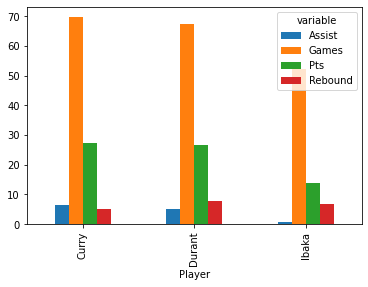

In [18]:
player_stats.unstack().plot.bar()

This particular visualization would be helpful if we wanted to see which stats for which each player is strongest.
For example, we can see that Steph Curry scores far more points than he does rebound, but Serge Ibaka is a bit more balanced.
What if we wanted to be able to compare all players for each statistic?
This would be easier to do if the bars were grouped by variable, with a different bar for each player.
To plot this, we need to have the variables on the index and the player name as column names.
We can get this DataFrame by setting `level="Player"` when calling unstack.

In [19]:
player_stats.unstack(level="Player")

Player,Curry,Durant,Ibaka
variable,,,
Assist,6.466667,5.066667,0.866667
Games,69.666667,67.333333,52.333333
Pts,27.266667,26.566667,13.966667
Rebound,5.000000,7.766667,6.800000


<AxesSubplot:xlabel='variable'>

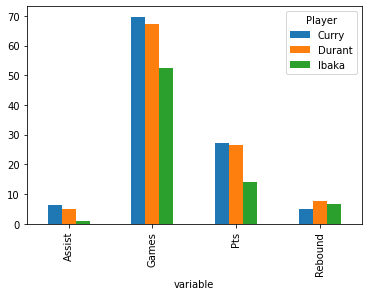

In [20]:
player_stats.unstack(level="Player").plot.bar()

Now we can use the chart to make a number of statements about players:
- Ibaka does not get many assists, compared to Curry and Durant.
- Steph and Kevin Durant are both high scorers.

Based on the examples above, notice a few things about `unstack`:
- It is the *inverse* of `stack`; `stack` will move labels down from columns to index, while unstack moves them up from index to columns.
- By default, `unstack` will move the level of the index closest to the data and place it in the column labels closest to the data.

> **Note**
>
> Just as we can pass multiple levels to `stack`, we can also pass multiple levels to `unstack`.
>
> We needed to use this in our solution to the exercise below.

### Summary
In some ways `set_index`, `reset_index`, `stack`, and unstack are the “most fundamental” reshaping operations…
The other operations we discuss can be formulated with these four operations (and, in fact, some of them are exactly written as these operations in pandas’s code base).

*Pro tip*: We remember stack vs unstack with a mnemonic: **U**nstack moves index levels **U**p

`melt`

The `melt` method is used to move from wide to long form.
It can be used to move all of the “values” stored in your DataFrame to a single column with all other columns being used to contain identifying information.

> **Warning**
>
> When you use `melt`, any index that you currently have will be deleted.

We saw used `melt` above when we constructed `bball_long`:

In [ ]:
bball

In [ ]:
# this is how we made ``bball_long``
bball.melt(id_vars=["Year", "Player", "Team", "TeamName"])

Notice that the columns we specified as `id_vars` remained columns, but all other columns were put into two new columns:
1. `variable`: This has dtype string and contains the former column names. as values
1. `value`: This has the former values.

Using this method is an effective way to get our data in *tidy* form as noted above.

# `pivot` and `pivot_table`
The next two reshaping methods that we will use are closely related.
Some of you might even already be familiar with these ideas because you have previously used *pivot tables* in Excel.
- If so, good news. We think this is even more powerful than Excel and easier to use!
- If not, good news. You are about to learn a very powerful and user-friendly tool.

We will begin with `pivot`.
The `pivot` method:
- Takes the unique values of one column and places them along the index.
- Takes the unique values of another column and places them along the columns.
- Takes the values that correspond to a third column and fills in the DataFrame values that correspond to that index/column pair.

We’ll illustrate with an example.

In [ ]:
# .head 6 excludes Ibaka -- will discuss why later
bball.head(6).pivot(index="Year", columns="Player", values="Pts")

We can replicate `pivot` using three of the fundamental operations from above:
1. Call `set_index` with the index and columns arguments
1. Extract the values column
1. `unstack` the columns level of the new index

In [ ]:
#  1---------------------------------------  2---  3----------------------
bball.head(6).set_index(["Year", "Player"])["Pts"].unstack(level="Player")

One important thing to be aware of is that in order for `pivot` to work, the index/column pairs must be *unique*!
Below, we demonstrate the error that occurs when they are not unique.

In [ ]:
# Ibaka shows up twice in 2016 because he was traded mid-season from
# the Orlando Magic to the Toronto Raptors
bball.pivot(index="Year", columns="Player", values="Pts")

`pivot_table`

The `pivot_table` method is a generalization of `pivot`.
It overcomes two limitations of `pivot`:
1. It allows you to choose multiple columns for the index/columns/values arguments.
1. It allows you to deal with duplicate entries by having you choose how to combine them.

In [ ]:
bball

Notice that we can replicate the functionality of `pivot` using `pivot_table` if we pass the same arguments.

In [ ]:
bball.head(6).pivot_table(index="Year", columns="Player", values="Pts")

But we can also choose multiple columns to be used in index/columns/values.

In [ ]:
bball.pivot_table(index=["Year", "Team"], columns="Player", values="Pts")

In [ ]:
bball.pivot_table(index="Year", columns=["Player", "Team"], values="Pts")

`AND` we can deal with duplicated index/column pairs.

In [ ]:
# This produced an error
# bball.pivot(index="Year", columns="Player", values="Pts")

# This doesn't!
bball_pivoted = bball.pivot_table(index="Year", columns="Player", values="Pts")
bball_pivoted

`pivot_table` handles duplicate index/column pairs using an aggregation.
By default, the aggregation is the mean.

For example, our duplicated index/column pair is `("x", 1)` and had associated values of 2 and 5.
Notice that `bball_pivoted.loc[2016, "Ibaka"]` is `(15.1 + 14.2)/2 = 14.65`.

We can choose how pandas aggregates all of the values.
For example, here’s how we would keep the max.

In [ ]:
bball.pivot_table(index="Year", columns="Player", values="Pts", aggfunc=max)

Maybe we wanted to count how many values there were.

In [ ]:
bball.pivot_table(index="Year", columns="Player", values="Pts", aggfunc=len)

We can even pass multiple aggregation functions!

In [ ]:
bball.pivot_table(index="Year", columns="Player", values="Pts", aggfunc=[max, len])

# Visualizing Reshaping
Now that you have learned the basics and had a chance to experiment, we will use some generic data to provide a visualization of what the above reshape operations do.

The data we will use is:

In [ ]:
# made up
# columns A and B are "identifiers" while C, D, and E are variables.
df = pd.DataFrame({
    "A": [0, 0, 1, 1],
    "B": "x y x z".split(),
    "C": [1, 2, 1, 4],
    "D": [10, 20, 30, 20,],
    "E": [2, 1, 5, 4,]
})

df.info()
df

In [ ]:
df2 = df.set_index(["A", "B"])
df2.head()

In [ ]:
df3 = df2.T
df3.head()

# `stack` and `unstack`
Below is an animation that shows how stacking works.

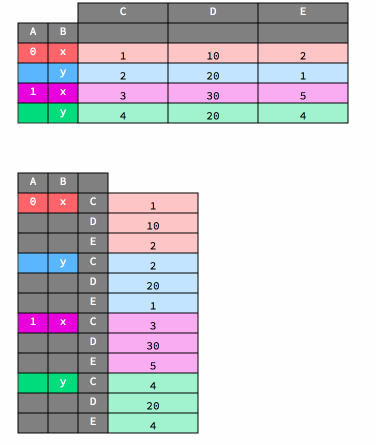

In [ ]:
df2

In [ ]:
df2_stack = df2.stack()
df2_stack

And here is an animation that shows how unstacking works.

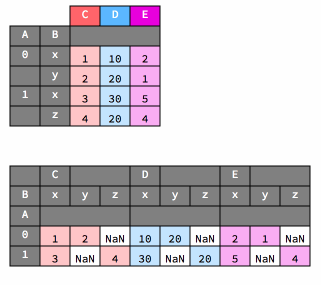

In [ ]:
df2

In [ ]:
df2.unstack()

`melt`

As noted above, the `melt` method transforms data from wide to long in form.
Here’s a visualization of that operation.

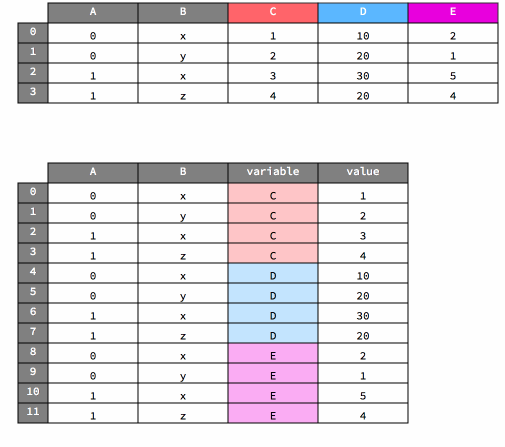

In [ ]:
df

In [ ]:
df_melted = df.melt(id_vars=["A", "B"])
df_melted